In [145]:
import os
import wfdb
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import signal
from sklearn.impute import SimpleImputer
from keras import Input, Model
from keras.api.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from keras.api.layers import Dense, Flatten, Conv1D, Concatenate, Reshape, LeakyReLU, BatchNormalization, Dropout, Conv1DTranspose
from keras.api.metrics import Precision, Recall, Accuracy

%matplotlib inline

In [146]:
ECG_names = sorted(os.listdir("dataset"))
ECG_names = [name for name in ECG_names if not any(exclude in name for exclude in ['02076', '02089', '02148', '02152'])]
scaler = StandardScaler()
all_ecgs = []

def downsample_ecg(ecg, samples=128):
    '''
    
    '''
    time_len, n_leads = ecg.shape
    new_ecg = np.zeros((samples, n_leads))
    for lead_idx in range(n_leads):
        lead_data = ecg[:, lead_idx]
        new_ecg[:, lead_idx] = signal.resample(lead_data, samples)
    return new_ecg


def load_data():
    '''
    
    '''
    combined_data = []
    CRFs = load_and_process_crf_data()
    idx = 0
    for ecgfilename in tqdm(ECG_names):
        if ecgfilename.endswith(".dat"):
            ecgfilename = ecgfilename.strip(".dat")
            data = __load_ecg_data(f"dataset/{ecgfilename}")[0]
            ecg_downsampled = downsample_ecg(data)
            all_ecgs.append(ecg_downsampled)
            combined_data.append((ecg_downsampled, CRFs.iloc[idx].values))
            idx += 1
    return combined_data


def __load_ecg_data(filename):
    '''
    
    '''
    x = wfdb.rdrecord(filename, sampfrom=20000, sampto=20000+(128*60),channels=[0,1,2])
    data = np.asarray(x.p_signal, dtype=np.float64)
    new_file = f"{filename}.hea"
    input_header_file = os.path.join(new_file)
    with open(input_header_file, 'r') as f:
        header_data = f.readlines()
    return data, header_data


def load_and_process_crf_data():
    '''
    
    '''
    CRFs = pd.read_csv(f"CRFs.csv")
    CRFs = CRFs[~CRFs['Record'].isin(['02076', '02089', '02148', '02152'])]
    CRFs = CRFs.drop(columns=['Record','IMT MAX', 'LVMi', 'EF'])
    CRFs['Gender'] = CRFs['Gender'].str.upper().map({'M':0, 'F':1})
    CRFs['Smoker'] = CRFs['Smoker'].str.upper().map({'NO':0, 'YES': 1})
    CRFs['Vascular event'] = CRFs['Vascular event'].str.lower().map({'none': 0, 'myocardial infarction': 1, 'stroke': 2, 'syncope': 3})
    num_imputer = SimpleImputer(strategy='mean')
    CRFs[['SBP', 'DBP']] = num_imputer.fit_transform(CRFs[['SBP', 'DBP']])
    num_cols = ['Age','Weight','Height','SBP','DBP','BSA','BMI']
    CRFs[num_cols] = scaler.fit_transform(CRFs[num_cols])
    # print(np.isnan(CRFs).any())
    # print(np.isinf(CRFs).any())
    return CRFs

def normalize_ecg(ecg, global_min, global_max):
    if global_max == global_min:
        return ecg
    ecg_norm = (ecg - global_min) / (global_max - global_min)
    ecg_norm = 2 * ecg_norm - 1
    return ecg_norm

In [147]:
combined_data = load_data()

all_ecgs = np.vstack(all_ecgs)
global_min = np.min(all_ecgs)
global_max = np.max(all_ecgs)

normalized_ecg_dataset = []
for ecg, crf in combined_data:
    ecg_norm = normalize_ecg(ecg, global_min=global_min,global_max=global_max)
    normalized_ecg_dataset.append((ecg_norm,crf))

100%|██████████| 405/405 [00:00<00:00, 966.08it/s]


In [148]:
def reverse_crf_normalization(crf,scaler : StandardScaler,col_names):
    original_crf = scaler.inverse_transform(crf)
    return pd.DataFrame(original_crf, columns=col_names)


def reverse_ecg_normalization(normalized_ecg, min_value, max_value):
    scaled_ecg = (normalized_ecg + 1) /  2
    original_ecg = scaled_ecg * (max_value - min_value) + min_value
    return original_ecg

In [149]:
def build_generator(latent_dim=100, cond_dim=10, ecg_length=128, n_leads=3, crf_dim=10):
    noise_input = Input(shape=(latent_dim,), name='noise input')
    input_condition = Input(shape=(cond_dim,), name='cond input')
    # Combined noise and condition to generate
    combined_input = Concatenate(name='concat_noise_cond')([noise_input, input_condition])
    # ECG leads generation
    x = Dense(256, activation=LeakyReLU(0.2))(combined_input)
    x_ecg = Dense(16*64, activation=LeakyReLU(0.2))(x)
    x_ecg = Reshape((16,64))(x_ecg)
    x_ecg = Conv1DTranspose(64, kernel_size=4,strides=2,padding='same')(x_ecg)
    x_ecg = LeakyReLU(0.2)(x_ecg)
    x_ecg = Conv1DTranspose(64, kernel_size=4, strides=2, padding='same')(x_ecg)  # 32 -> 64
    x_ecg = LeakyReLU(0.2)(x_ecg)
    x_ecg = Conv1DTranspose(32, kernel_size=4, strides=2, padding='same')(x_ecg)  # 64 -> 128
    x_ecg = LeakyReLU(0.2)(x_ecg)
    gen_ecg = Conv1D(filters=n_leads,kernel_size=7,padding='same',activation='tanh',name='gen_ecg')(x_ecg)
    # Clinical risk factors generation
    x_crf = Dense(128, activation='relu')(combined_input)
    gen_crf = Dense(crf_dim, activation='tanh')(x_crf)
    # Return model with inputs and outputs along with name
    generator = Model([noise_input, input_condition], [gen_ecg, gen_crf], name="Generator")
    return generator

In [150]:
def build_discriminator(ecg_length=128,n_leads=3,crf_dim=10,cond_dim=10):
    ecg_input = Input(shape=(ecg_length, n_leads), name='ecg_input')
    crf_input = Input(shape=(crf_dim,), name='crf_input')
    input_condition = Input(shape=(cond_dim,), name='cond_input')


    x_ecg = Conv1D(64,kernel_size=5, strides=2, padding='same')(ecg_input)
    x_ecg = LeakyReLU(negative_slope=0.2)(x_ecg)
    x_ecg = Conv1D(128, kernel_size=5, strides=2, padding='same')(x_ecg)
    x_ecg = LeakyReLU(negative_slope=0.2)(x_ecg)
    x_ecg = Conv1D(256, kernel_size=5, strides=2, padding='same')(x_ecg)
    x_ecg = LeakyReLU(negative_slope=0.2)(x_ecg)
    x_ecg = Flatten()(x_ecg)

    combined_input = Concatenate()([crf_input, input_condition])
    x_crf = Dense(64, activation=LeakyReLU(negative_slope=0.2))(combined_input)
    x_crf = Dense(64, activation=LeakyReLU(negative_slope=0.2))(x_crf)

    combined = Concatenate()([x_ecg, x_crf])
    combined = Dense(128, activation=LeakyReLU(0.2))(combined)
    x_combined = Dense(1, activation='sigmoid', name='Validity')(combined)

    discriminator = Model([ecg_input, crf_input, input_condition], x_combined, name="Discriminator")
    
    return discriminator

In [151]:
def gradient_penalty(discriminator, real_samples, fake_samples, real_conditions):
    alpha = tf.random.uniform((real_samples.shape[0], 1, 1), 0.0, 1.0)
    interpolates = alpha * real_samples + (1 - alpha) * fake_samples
    interpolates = tf.convert_to_tensor(interpolates, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(interpolates)
        predictions = discriminator([interpolates, real_conditions, real_conditions])

    gradients = tape.gradient(predictions, [interpolates])[0]
    gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1,2]))
    gradient_penalty = tf.reduce_mean((gradients_norm - 1.0) ** 2)
    return gradient_penalty

In [152]:
def train_wgan_gp(dataset, epochs=1000, batch_size=16, latent_dim=100, critic_updates=5, lambda_gp=10):
    generator = build_generator()
    discriminator = build_discriminator()

    generator_optimizer = Adam(1e-4, beta_1=0.5)
    discriminator_optimizer = Adam(1e-5, beta_1=0.5)
    
    for epoch in range(epochs):
        for _ in range(critic_updates):
            idxs = np.random.randint(0, len(dataset), batch_size)
            real_ecgs = []
            real_crfs = []
            for i in idxs:
                ecg_data, crf_data = dataset[i]
                real_crfs.append(crf_data)
                real_ecgs.append(ecg_data)
            real_ecgs = tf.convert_to_tensor(real_ecgs, dtype=tf.float32)
            real_crfs = tf.convert_to_tensor(real_crfs, dtype=tf.float32)

            # Generate fake data
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            noise = tf.convert_to_tensor(noise, dtype=tf.float32)
            fake_ecgs, fake_crfs = generator([noise, real_crfs], training=True)

            fake_ecgs = tf.convert_to_tensor(fake_ecgs, dtype=tf.float32)
            fake_crfs = tf.convert_to_tensor(fake_crfs, dtype=tf.float32)

            # Calculate losses
            with tf.GradientTape() as tape:
                real_validity = discriminator([real_ecgs, real_crfs, real_crfs], training=True)
                fake_validity = discriminator([fake_ecgs, fake_crfs, real_crfs], training=True)
                gp = gradient_penalty(discriminator, real_ecgs, fake_ecgs, real_crfs)
                d_loss = tf.reduce_mean(fake_validity) - tf.reduce_mean(real_validity) + lambda_gp * gp

            # Update discriminator
            grads = tape.gradient(d_loss, discriminator.trainable_weights)
            discriminator_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        noise = tf.convert_to_tensor(noise, dtype=tf.float32)
        with tf.GradientTape() as tape:
            fake_ecgs, fake_crfs = generator([noise, real_crfs])
            fake_ecgs = tf.convert_to_tensor(fake_ecgs, dtype=tf.float32)
            fake_crfs = tf.convert_to_tensor(fake_crfs, dtype=tf.float32)
            g_loss = -tf.reduce_mean(discriminator([fake_ecgs, fake_crfs, real_crfs]))

        # Update generator
        grads = tape.gradient(g_loss, generator.trainable_weights)
        generator_optimizer.apply_gradients(zip(grads, generator.trainable_weights))

        # Logging and visualization
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")
            original_ecg = reverse_ecg_normalization(fake_ecgs[0][0],global_min,global_max)
            plt.plot(original_ecg)
            plt.title("Generated Lead I")
            plt.show()

In [153]:
def train_gan(generator : Model, discriminator : Model, dataset, latent_dim=100, cond_dim=10, batch_size=32, epochs=1000):
    '''
    GAN training function. Builds the discriminator and generator networks.
    Compiles both networks, combined gen & discriminator network and discriminator network,
    sets discriminator to not trainable.

    Trains on the provided pre-processed dataset for the given number of epochs
    '''
    z = Input(shape=(latent_dim,))
    c = Input(shape=(cond_dim,))
    ecg_gen, crf_gen = generator([z, c])
    validity = discriminator([ecg_gen, crf_gen, c])
    combined = Model([z, c], validity, name='CombinedGAN')
    combined.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=1e-4, beta_1=0.5))
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4, beta_1=0.5), metrics=['accuracy'])
    discriminator.trainable = False
    # Training loop
    real_label = np.ones((batch_size, 1))
    fake_label = np.zeros((batch_size, 1))
    for epoch in range(epochs):
        discriminator.trainable = True
        idx = np.random.randint(0, len(dataset), batch_size)
        real_ecgs = []
        real_crfs = []
        for i in idx:
            ecg_data, crf_data = dataset[i]
            real_crfs.append(crf_data)
            real_ecgs.append(ecg_data)
        real_ecgs = np.array(real_ecgs)
        real_crfs = np.array(real_crfs)

        z_rand = np.random.normal(0, 1, (batch_size, latent_dim))
        ecg_fake, crf_fake = generator.predict([z_rand, real_crfs])
        d_loss_real = discriminator.train_on_batch([real_ecgs, real_crfs, real_crfs], real_label)
        d_loss_fake = discriminator.train_on_batch([ecg_fake, crf_fake, real_crfs], fake_label)
        
        discriminator.trainable = False
        z_rand = np.random.normal(0, 1, (batch_size,latent_dim))
        g_loss = combined.train_on_batch([z_rand, real_crfs], real_label)

        if epoch % 10 == 0:
            original_ecg = reverse_ecg_normalization(ecg_fake[0,:,0],global_min,global_max)
            plt.plot(original_ecg)
            plt.title("Lead II")
            plt.show()
            print(f"Epoch {epoch} | "f"D Loss: Real={d_loss_real[0]:.4f}, Fake={d_loss_fake[0]:.4f} | "f"G Loss={g_loss:.4f}")

    
    combined.save(f"gan/Model.keras")

/home/elukbog/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['noise input', 'cond input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


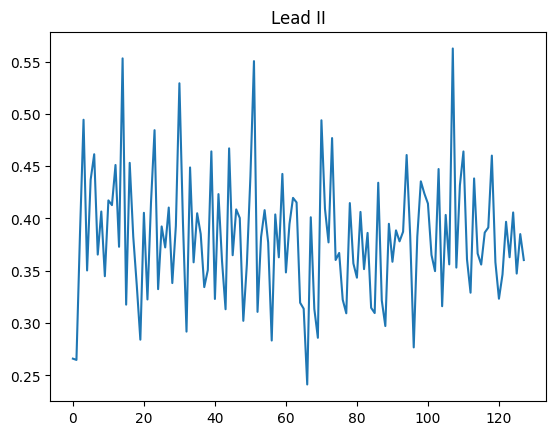

Epoch 0 | D Loss: Real=0.6703, Fake=0.6855 | G Loss=0.6869
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


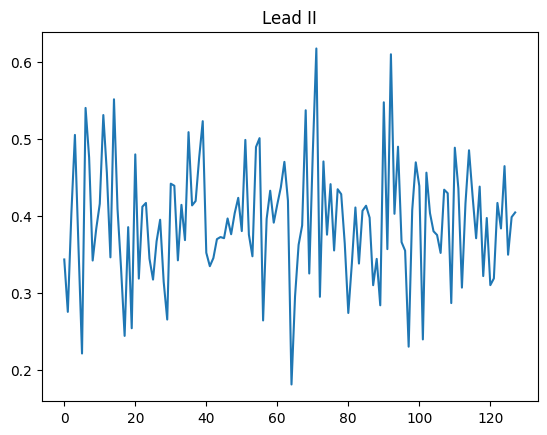

Epoch 10 | D Loss: Real=0.6171, Fake=0.6233 | G Loss=0.6666
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


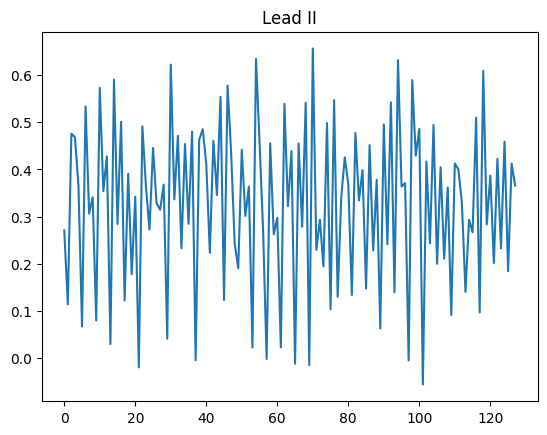

Epoch 20 | D Loss: Real=0.5453, Fake=0.5485 | G Loss=0.6743
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


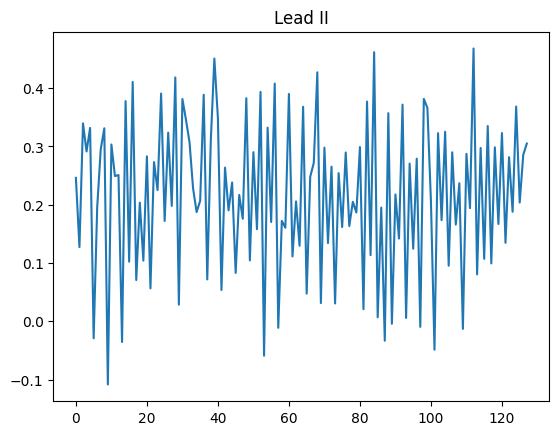

Epoch 30 | D Loss: Real=0.4878, Fake=0.4888 | G Loss=0.7339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


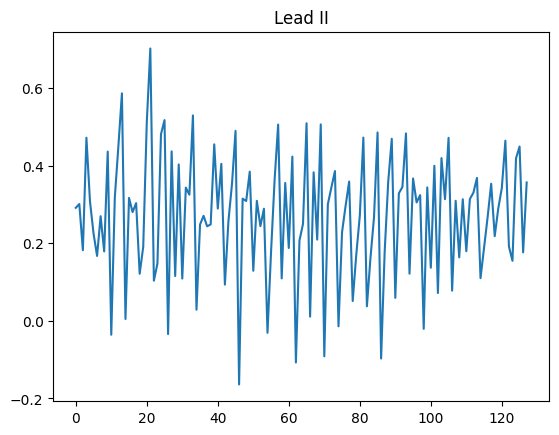

Epoch 40 | D Loss: Real=0.4538, Fake=0.4551 | G Loss=0.7923
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


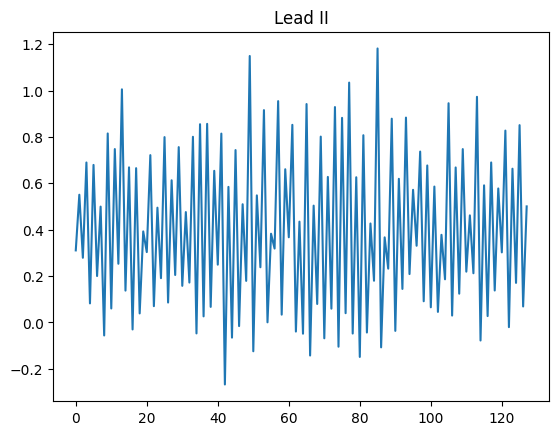

Epoch 50 | D Loss: Real=0.4244, Fake=0.4223 | G Loss=0.9214
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


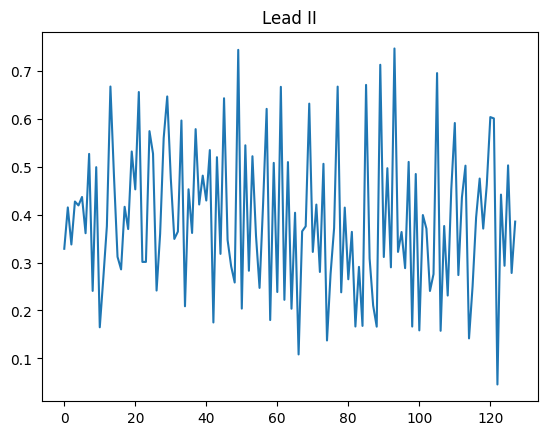

Epoch 60 | D Loss: Real=0.3804, Fake=0.3801 | G Loss=1.0651
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


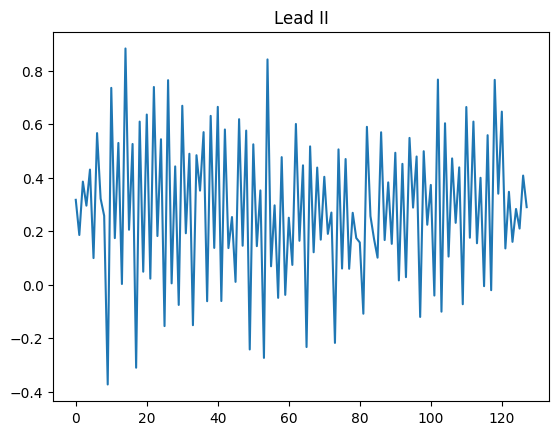

Epoch 70 | D Loss: Real=0.3639, Fake=0.3632 | G Loss=1.1457
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


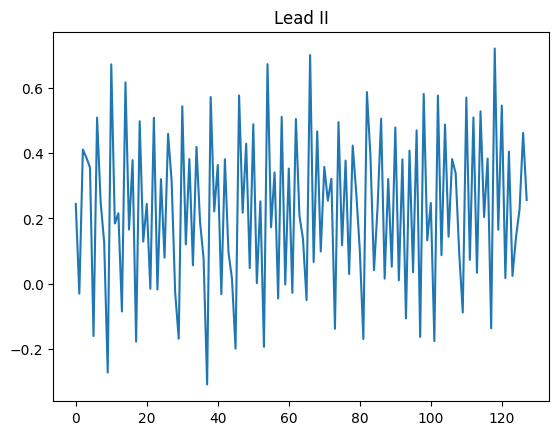

Epoch 80 | D Loss: Real=0.3382, Fake=0.3371 | G Loss=1.2834
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


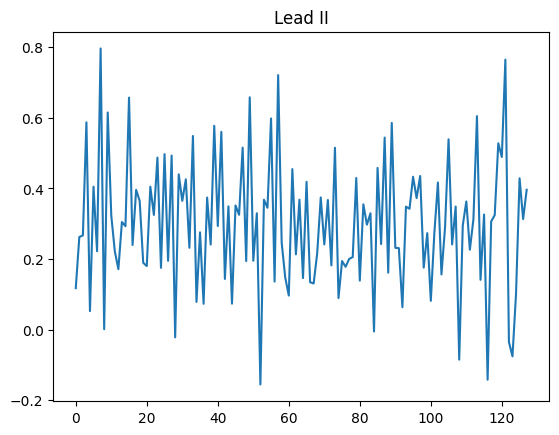

Epoch 90 | D Loss: Real=0.3142, Fake=0.3129 | G Loss=1.4431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


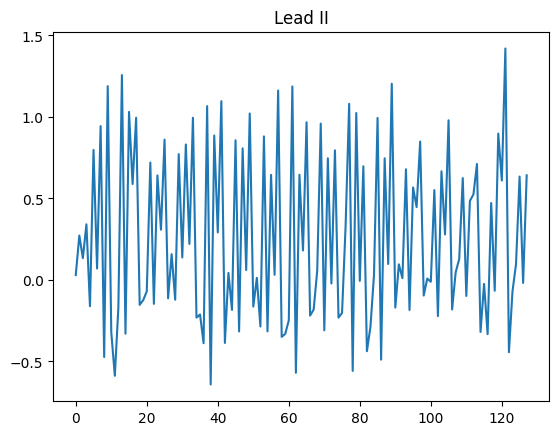

Epoch 100 | D Loss: Real=0.2907, Fake=0.2896 | G Loss=1.6243
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


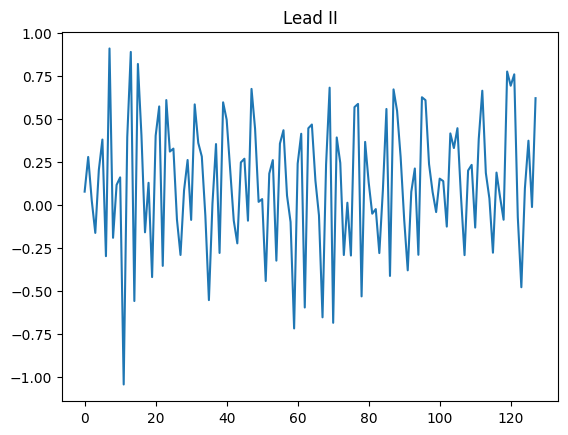

Epoch 110 | D Loss: Real=0.2733, Fake=0.2726 | G Loss=1.7717
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


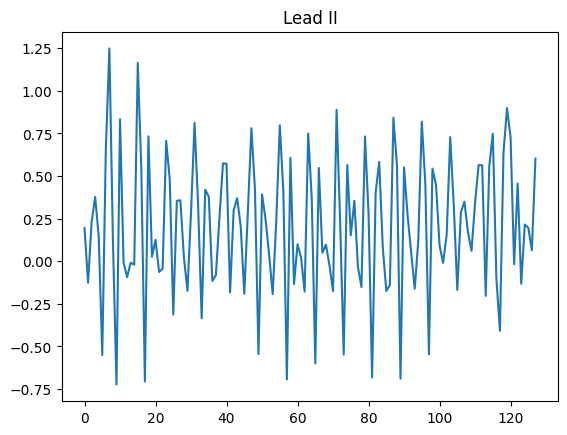

Epoch 120 | D Loss: Real=0.2687, Fake=0.2680 | G Loss=1.9196
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


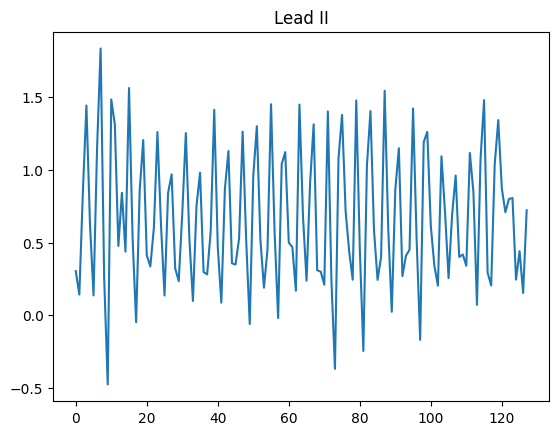

Epoch 130 | D Loss: Real=0.2619, Fake=0.2615 | G Loss=2.1134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


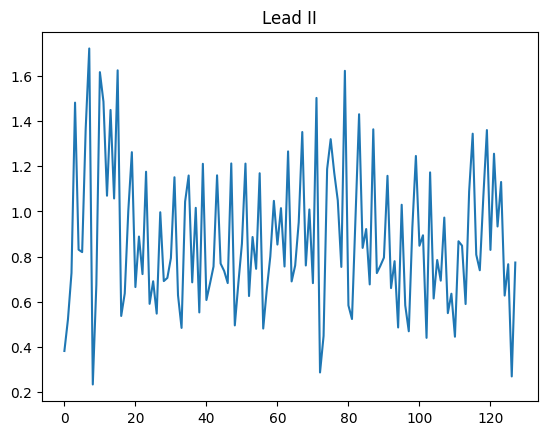

Epoch 140 | D Loss: Real=0.2584, Fake=0.2585 | G Loss=2.3489
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


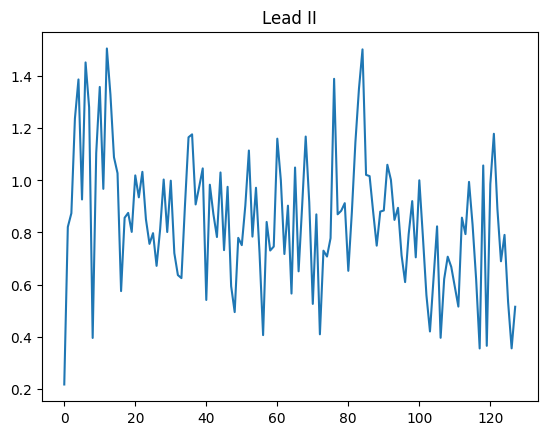

Epoch 150 | D Loss: Real=0.2594, Fake=0.2586 | G Loss=2.5248
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


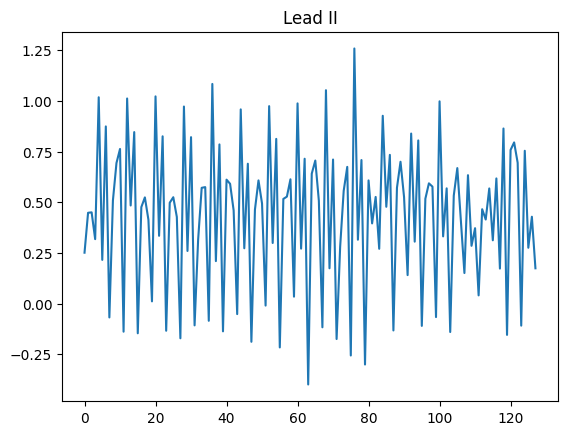

Epoch 160 | D Loss: Real=0.2849, Fake=0.2845 | G Loss=2.6182
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


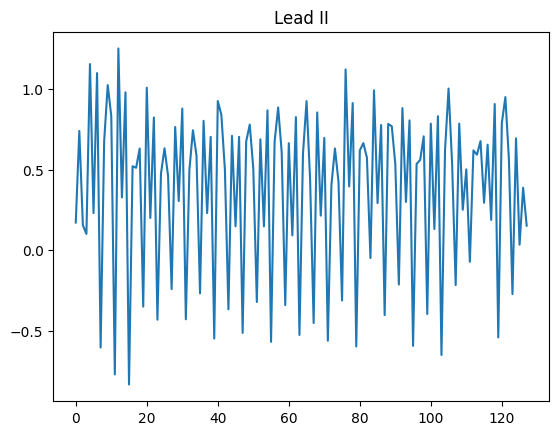

Epoch 170 | D Loss: Real=0.2982, Fake=0.2979 | G Loss=2.6212
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


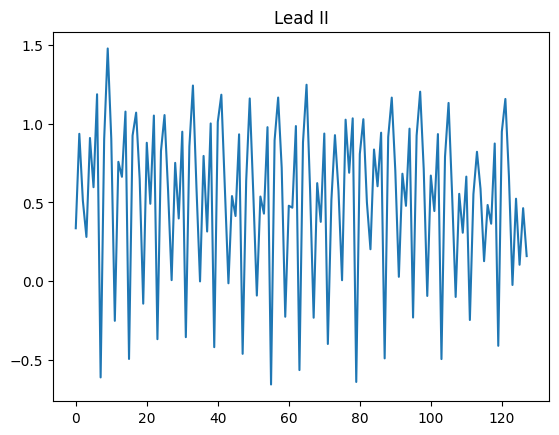

Epoch 180 | D Loss: Real=0.2890, Fake=0.2886 | G Loss=2.6465
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


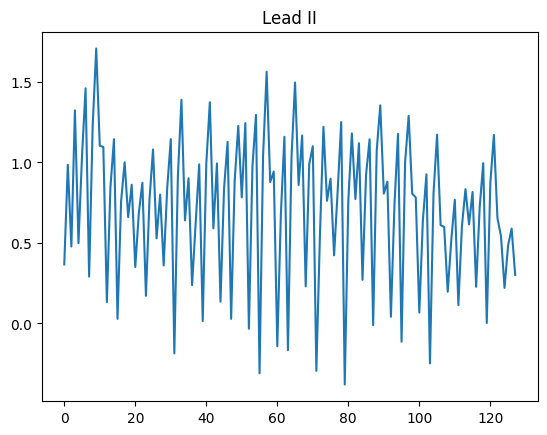

Epoch 190 | D Loss: Real=0.2834, Fake=0.2834 | G Loss=2.6941
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


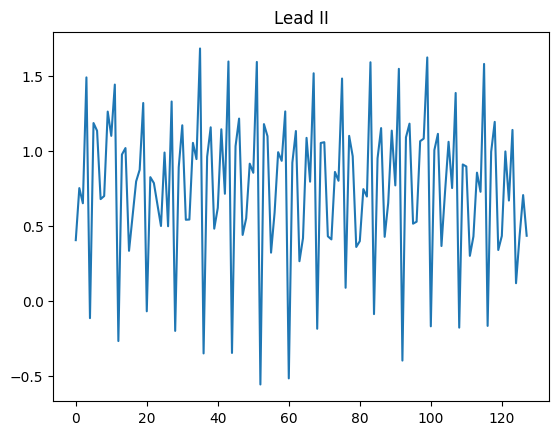

Epoch 200 | D Loss: Real=0.2776, Fake=0.2772 | G Loss=2.7347
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


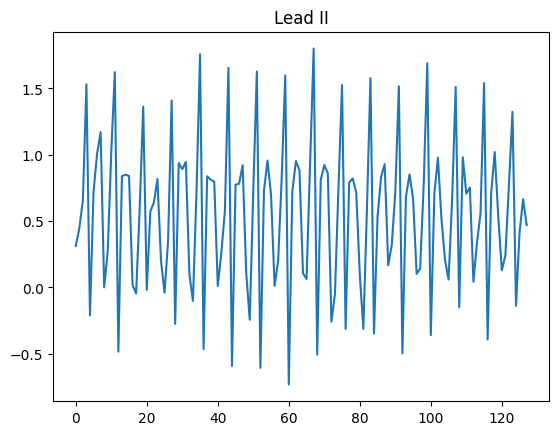

Epoch 210 | D Loss: Real=0.2714, Fake=0.2711 | G Loss=2.7617
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


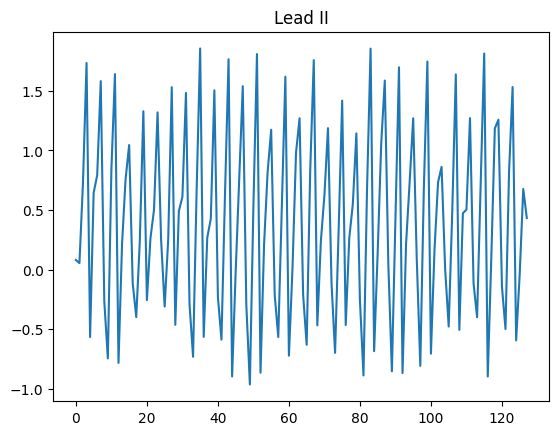

Epoch 220 | D Loss: Real=0.2647, Fake=0.2643 | G Loss=2.7732
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


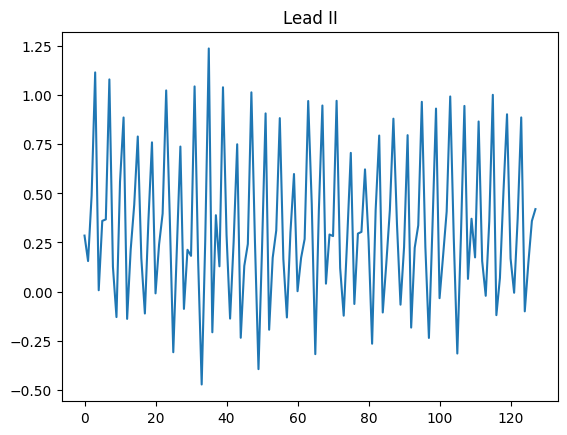

Epoch 230 | D Loss: Real=0.2574, Fake=0.2571 | G Loss=2.7886
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


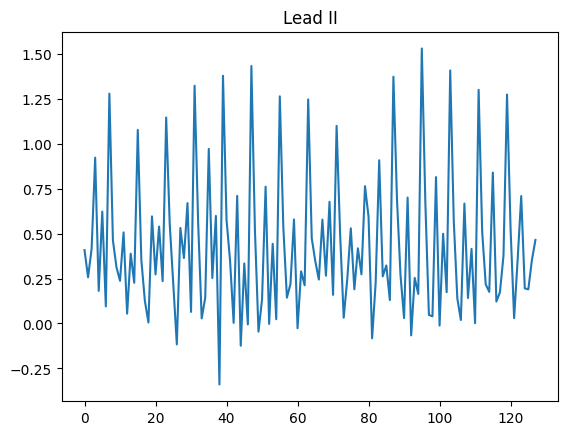

Epoch 240 | D Loss: Real=0.2518, Fake=0.2515 | G Loss=2.8059
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


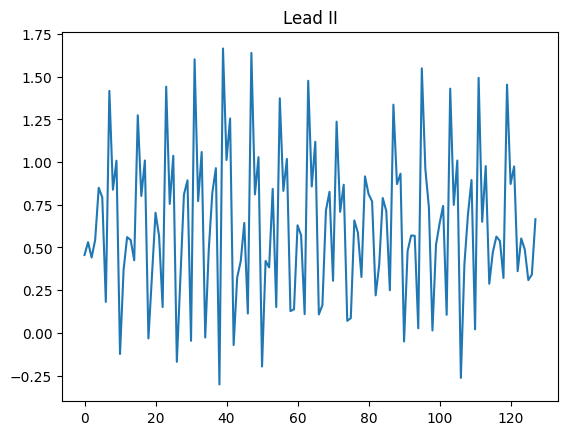

Epoch 250 | D Loss: Real=0.2484, Fake=0.2480 | G Loss=2.8254
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


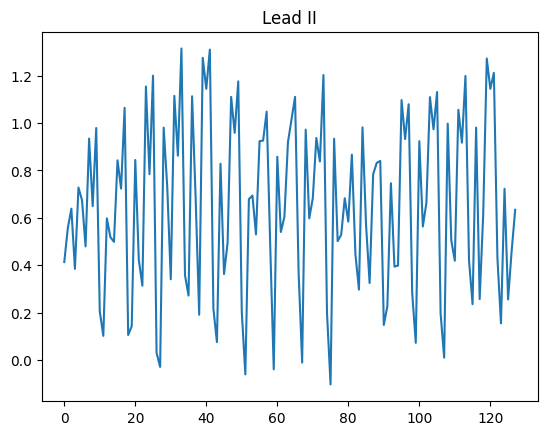

Epoch 260 | D Loss: Real=0.2461, Fake=0.2460 | G Loss=2.8367
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


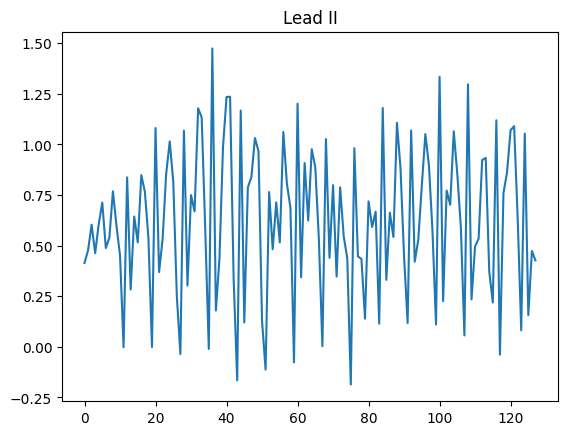

Epoch 270 | D Loss: Real=0.2434, Fake=0.2432 | G Loss=2.8419
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


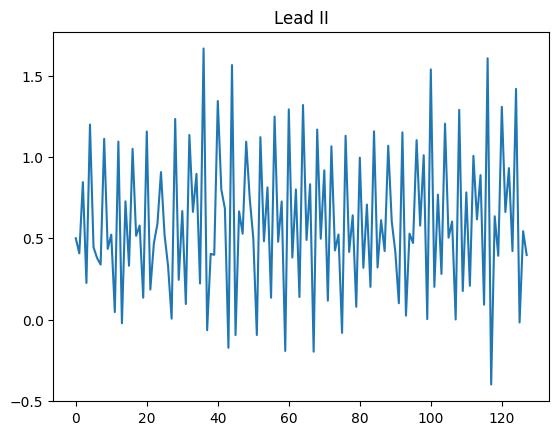

Epoch 280 | D Loss: Real=0.2391, Fake=0.2388 | G Loss=2.8517
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


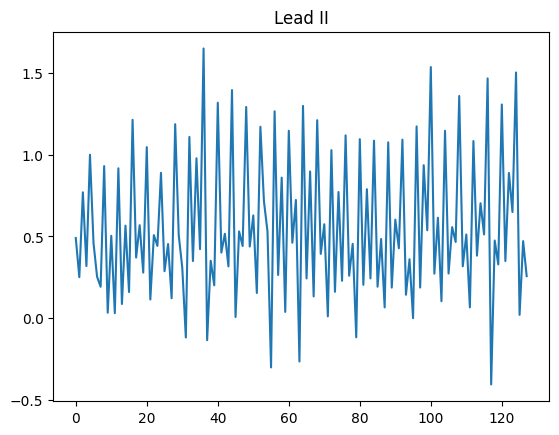

Epoch 290 | D Loss: Real=0.2336, Fake=0.2333 | G Loss=2.8633
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


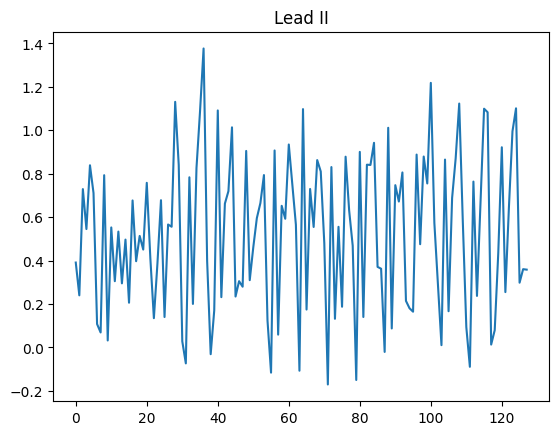

Epoch 300 | D Loss: Real=0.2291, Fake=0.2289 | G Loss=2.8719
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


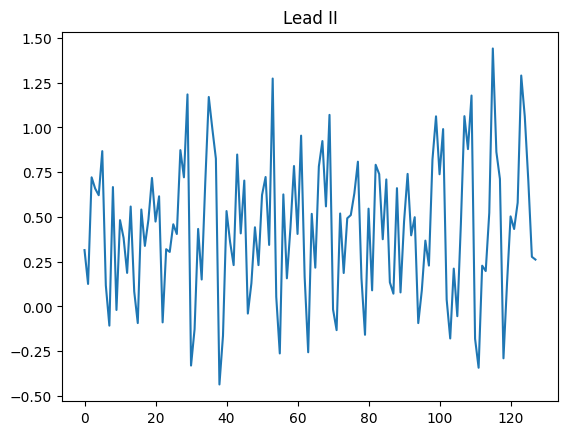

Epoch 310 | D Loss: Real=0.2263, Fake=0.2263 | G Loss=2.8793
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


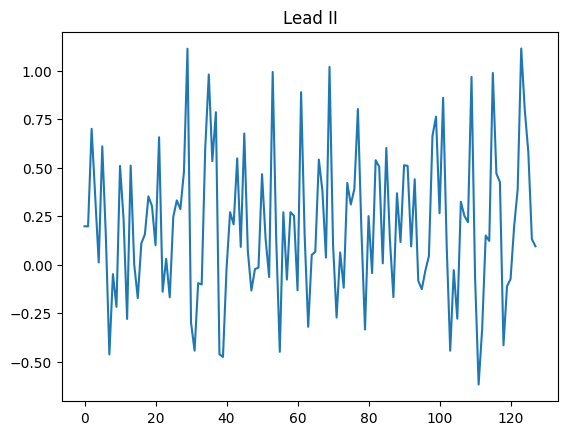

Epoch 320 | D Loss: Real=0.2248, Fake=0.2245 | G Loss=2.8916
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


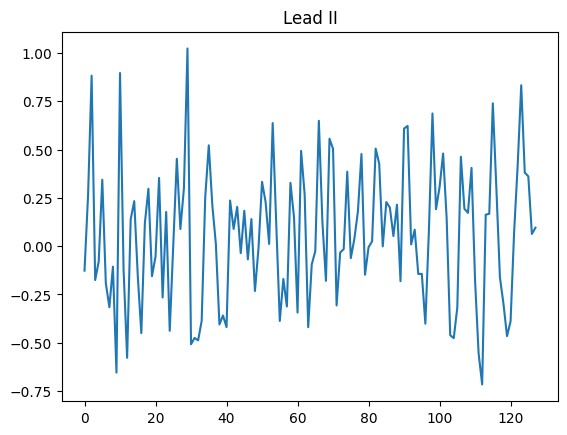

Epoch 330 | D Loss: Real=0.2219, Fake=0.2218 | G Loss=2.9117
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


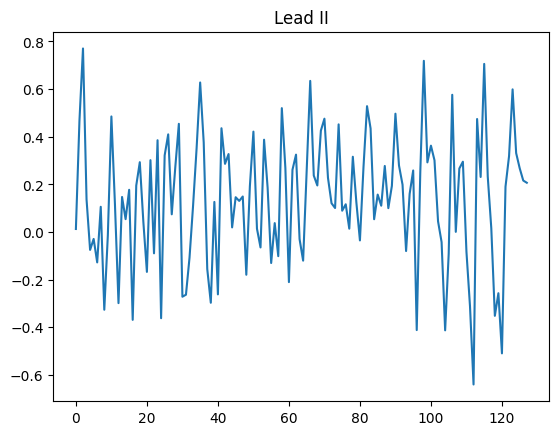

Epoch 340 | D Loss: Real=0.2217, Fake=0.2217 | G Loss=2.9368
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


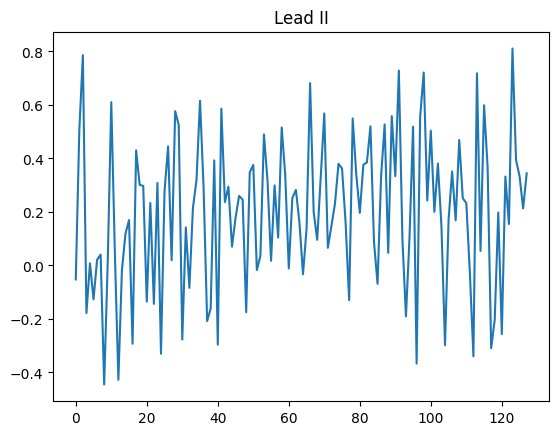

Epoch 350 | D Loss: Real=0.2208, Fake=0.2207 | G Loss=2.9641
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


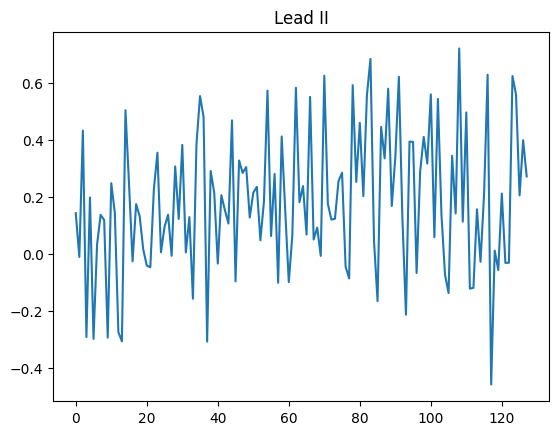

Epoch 360 | D Loss: Real=0.2229, Fake=0.2234 | G Loss=2.9835
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


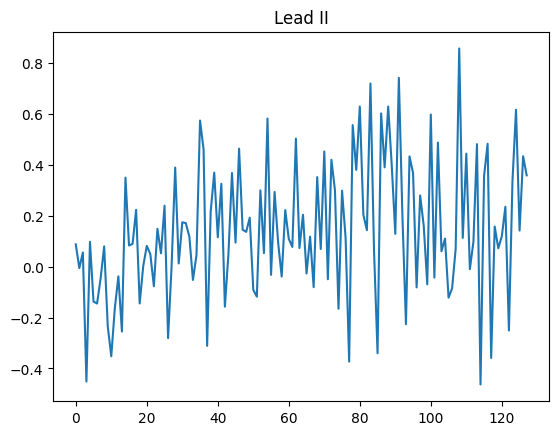

Epoch 370 | D Loss: Real=0.2235, Fake=0.2233 | G Loss=3.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
generator = build_generator()
discriminator = build_discriminator()

train_gan(generator, discriminator, dataset=normalized_ecg_dataset, batch_size=32)
# train_wgan_gp(dataset=combined_data, batch_size=32)